**Добрый день, данная работ принадлежит студенту Яндекс Практикума - Максимовой Анне Дмитриевне, телеграмм аккаунт для связи Telegram @skorpioshka64**

Проект выполнялся в среде `Python` версии `3.9.18`

# **Разработка алгоритма нахождения наиболее похожих вариантов товара**

**Описание работы**

Проводим работы с табличными данными в которые входят анонимизированный набор товаров, каждый из которых имеет id и вектор признаков принадлежащих данному товару с размерностью 72. Нужно найти 5 наиболее близких товаров

**Задача:**

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5


**Этапы работы**

- Загрузка данных
- Первый взгляд на данные, обнаружение выбросов, аномалий
- Предобработка данных, удаление пропусков, аномалий и т.д.
- Разработка алгоритма на основе fiass
- Проверка работы алгоритма на данных
- Подготовка отчета по исследованию

**Исходные данные**

- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).
- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
- `validation_answer.csv` - правильные ответы к предыдущему файлу.

$$
accuracy@5 = 100 \times \left(\frac{\text{количество верно определенных похожих объектов из 5 возможных}}{\text{5}}\right)
$$

## Необходимые импорты

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import faiss
from matplotlib import rcParams, rcParamsDefault

In [2]:
!apt -q install libomp-dev -q

if sys.platform.startswith("darwin"):
    !pip  -q install faiss-cpu
else:
    !pip -q install faiss-gpu

The operation couldn’t be completed. Unable to locate a Java Runtime that supports apt.
Please visit http://www.java.com for information on installing Java.



In [3]:
# Устанавливает размер всех создаваемых графиков в дюймах
rcParams["figure.figsize"] = 7, 7
# отображать графики в формате SVG
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 1
# Получает значение DPI (точек на дюйм) по умолчанию для графиков.
default_dpi = rcParamsDefault["figure.dpi"]
# устанавливает значение DPI для графиков, умножая значение по умолчанию на factor
rcParams["figure.dpi"] = default_dpi * factor
# ограничивает максимальную ширину колонки
pd.options.display.max_colwidth = 50
# устанавливает максимальное количество отображаемых колонок
pd.options.display.max_columns = 50
# настройка отображения чисел с плавающей точкой
pd.set_option("display.float_format", "{:.3f}".format)

## Собственные функции

**Функция предобработки**

In [4]:
def preprocessing(df):
    print("Изучение данных датафрейма")
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)

    print(f"Размерность датафрейма составляет - {df.shape}")
    print("-" * 100)

    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)

    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)

    # Проверка на наличие пропусков
    print("Проверка на наличие пропусков:\n")
    missing_values = df.isna().sum().sum()
    print(missing_values)
    print("-" * 100)

    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)

    print("Вывод количества уникальных значений:\n")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))

**Функция оптимизация памяти**

In [5]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool = True) -> pd.DataFrame:
    """
    Function optimizes memory usage in dataframe
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    """

    # Типы, которые будем проверять на оптимизацию
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]

    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith("int"):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size:
        print(
            f"Размер использования памяти: до {before_size:5.2f} Mb - после {after_size:5.2f} Mb ({(before_size - after_size) / before_size:.1%})"
        )

    return df

**Функция построения квантиль графика (Q-Q) для проверки нормальности распределения данных**

In [6]:
def plot_qq_grids(df, rows=8, cols=9, figsize=(27, 24), title="Q-Q графики для всех столбцов"):
    """
    Создает сетку Q-Q графиков для всех числовых столбцов в DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    rows (int): Количество строк в сетке графиков.
    cols (int): Количество столбцов в сетке графиков.
    figsize (tuple): Размер фигуры.
    title (str): Заголовок для всей фигуры.
    """
    # Создание фигуры и осей
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=16)

    # Выбор только числовых столбцов
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Итерация по столбцам и построение Q-Q графиков
    for i, col in enumerate(numeric_columns):
        row = i // cols  # row вычисляет номер строки, в которой должен находиться график.
        col_pos = i % cols  # вычисляет номер столбца для текущего графика.
        ax = axes[row, col_pos]
        stats.probplot(df[col], dist="norm", plot=ax)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Удаление пустых графиков, если количество столбцов не кратно числу графиков в строке
    for j in range(len(numeric_columns), rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout(
        rect=[0, 0, 1, 0.96]
    )  # Подгонка макета и оставление места для основного заголовка
    plt.show()

**Функция загрузки данных**

In [7]:
def load_csv(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath, index_col=0)
    else:
        print(f"File not found: {filepath}")
        return None

## Загрузка данных

Загрузим сокращенный датасет, он пригодится нам для отладки алгоритма, на нем будем искать необходимое количество кластеров. И лучшие значения применим для полного. 

In [8]:
# Пути к файлам
pth1_short = "./datasets/base.csv"
pth2_short = "./datasets/train.csv"
pth3_short = "./datasets/validation.csv"
pth4_short = "./datasets/validation_answer.csv"

# Загрузка данных
df_base_short = load_csv(pth1_short)
df_train_short = load_csv(pth2_short)
df_validation_short = load_csv(pth3_short)
df_validation_answer_short = load_csv(pth4_short)

Загрузим полный датасет, на нем подробнее посмотрим на данные и осущесвим все необходимые преобразования

In [9]:
# Пути к файлам
pth1 = "./datasets_full/base.csv"
pth2 = "./datasets_full/train.csv"
pth3 = "./datasets_full/validation.csv"
pth4 = "./datasets_full/validation_answer.csv"

# Загрузка данных
df_base = load_csv(pth1)
df_train = load_csv(pth2)
df_validation = load_csv(pth3)
df_validation_answer = load_csv(pth4)

In [10]:
# Стандартизация названий колонок и оптимизация объема данных (сделаем сразу для полной и сокращенной базы)
for df in [
    df_base,
    df_train,
    df_validation,
    df_validation_answer,
    df_base_short,
    df_train_short,
    df_validation_short,
    df_validation_answer_short,
]:
    df.columns = df.columns.str.lower()
    df = optimize_memory_usage(df)

del df

Размер использования памяти: до 1625.25 Mb - после 823.75 Mb (49.3%)
Размер использования памяти: до 56.46 Mb - после 28.99 Mb (48.6%)
Размер использования памяти: до 55.69 Mb - после 28.23 Mb (49.3%)
Размер использования памяти: до  1.53 Mb - после  1.53 Mb (0.0%)
Размер использования памяти: до 162.52 Mb - после 82.38 Mb (49.3%)
Размер использования памяти: до  5.65 Mb - после  2.90 Mb (48.6%)
Размер использования памяти: до  5.57 Mb - после  2.82 Mb (49.3%)
Размер использования памяти: до  0.15 Mb - после  0.15 Mb (0.0%)


In [11]:
preprocessing(df_base)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.084,11.153,-64.427,-118.881,216.482,-104.698,-469.071,44.348,120.915,181.450,-124.062,-32.458,-57.421,36.207,182.717,-28.072,-5.209,-1.732,-91.092,-79.467,-103.939,1507.231,-32.592,51.414,-51.905,...,-138.068,91.000,-170.702,-50.020,59.794,78.106,-89.376,89.412,79.812,-129.514,-44.659,-80.442,5.150,-64.519,-138.778,-42.809,38.801,-151.762,-74.389,63.666,-4.704,92.934,115.269,-112.757,-60.830
1-base,-34.562,13.333,-69.788,-166.533,57.681,-86.098,-85.077,-35.637,119.719,195.234,-141.304,-126.769,-68.854,8.315,143.082,8.778,15.157,48.246,-244.955,-80.279,-81.788,429.880,-5.938,70.143,66.577,...,-189.010,-56.732,-30.027,59.171,-56.712,63.543,-121.319,97.426,74.833,-138.777,58.888,-71.595,-251.952,11.393,-148.572,-117.768,41.100,-157.829,-94.447,68.202,24.347,179.938,116.834,-84.889,-59.525
2-base,-54.234,6.379,-29.210,-133.414,150.896,-99.435,52.555,62.382,128.951,164.381,-140.822,-22.487,-51.667,2.522,140.585,-22.039,-7.129,-5.185,-111.712,-79.029,-82.453,1507.231,-0.421,84.108,63.345,...,-125.321,21.049,-22.638,68.916,-54.902,66.335,-142.928,83.031,69.980,-123.734,65.321,-114.037,-529.397,-101.581,-134.658,-76.398,46.012,-207.144,127.326,65.566,66.326,81.073,116.594,-1074.465,-32.527
3-base,-87.520,4.038,-87.803,-185.068,76.370,-58.985,-383.183,-33.611,122.032,136.234,-108.470,-104.538,-82.388,-79.987,113.596,-38.996,-4.787,8.328,-124.856,-79.109,-107.943,1479.171,-125.272,24.656,-16.921,...,-63.769,29.217,-26.424,5.870,64.062,63.513,-112.258,80.927,72.636,-137.314,7.913,-62.189,-540.321,-89.589,-149.327,-70.648,-6.359,-147.201,-37.693,66.203,-20.567,137.207,117.474,-1074.465,-72.915
4-base,-72.744,6.522,43.671,-140.608,5.820,-112.074,-397.711,45.182,122.167,112.119,-110.342,-38.982,-50.229,-26.691,135.273,-7.510,8.924,111.577,-130.833,-79.316,-57.844,1262.920,19.226,59.812,76.160,...,-211.540,57.695,-67.823,-29.389,-34.124,54.711,-26.032,90.674,58.087,-134.782,77.620,-176.616,-529.762,-100.566,-125.317,-57.199,56.642,-159.352,85.945,66.766,-2.506,65.315,135.052,-1074.465,0.319


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (2918139, 72)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 2

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,...,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000,2918139.000
mean,-86.229,8.080,-44.581,-146.635,111.317,-71.991,-392.224,20.353,123.684,124.458,-143.140,-69.887,-41.265,7.588,148.985,-23.167,-0.937,-19.313,-137.271,-79.189,-98.254,1257.528,-6.825,56.674,26.696,...,-138.470,47.928,-32.382,26.584,-21.717,66.997,-117.898,88.028,69.205,-132.906,13.226,-119.600,-316.094,-64.943,-130.668,-79.023,33.297,-154.796,14.151,67.792,23.545,74.959,115.567,-799.339,-47.791
std,24.891,4.953,38.632,19.845,46.348,28.186,271.655,64.216,6.356,64.431,41.687,51.220,38.964,36.597,33.636,13.076,20.832,52.972,46.626,0.757,28.159,399.961,51.973,34.361,38.942,...,57.738,45.202,58.287,58.953,51.739,13.072,54.706,4.774,11.949,7.815,51.080,55.243,210.664,62.482,9.569,30.456,28.886,41.229,98.951,1.823,55.342,61.345,21.175,385.413,41.748
min,-199.469,-13.915,-240.073,-232.667,-105.583,-211.009,-791.470,-301.860,93.153,-173.872,-343.844,-368.453,-226.091,-175.624,-15.267,-85.917,-96.368,-272.566,-351.748,-83.152,-243.728,136.818,-238.287,-88.183,-143.183,...,-418.695,-145.388,-322.812,-280.273,-264.633,6.196,-381.264,65.581,14.082,-167.063,-196.184,-359.705,-681.042,-400.791,-171.349,-220.566,-88.508,-353.903,-157.594,59.509,-233.138,-203.602,15.724,-1297.932,-226.780
25%,-103.065,4.708,-69.559,-159.905,80.508,-91.380,-629.332,-22.221,119.484,81.768,-170.318,-104.033,-66.626,-16.944,125.966,-31.768,-15.155,-55.465,-167.585,-79.678,-116.843,1088.597,-42.244,33.295,0.556,...,-176.596,17.904,-69.947,-12.332,-56.282,58.464,-154.488,84.714,61.306,-138.104,-22.387,-157.432,-498.484,-106.553,-137.389,-98.764,16.989,-180.780,-71.300,66.581,-12.516,33.776,101.687,-1074.465,-75.666
50%,-86.231,8.039,-43.817,-146.777,111.873,-71.922,-422.202,20.805,123.892,123.498,-141.716,-70.227,-40.397,8.128,149.315,-22.910,-1.033,-19.805,-136.804,-79.178,-97.528,1507.231,-6.418,56.999,27.131,...,-137.381,46.966,-29.174,27.506,-22.215,67.224,-117.627,88.012,69.359,-132.826,13.113,-120.459,-315.989,-63.689,-130.876,-78.488,34.715,-153.977,13.827,67.815,23.416,74.930,116.024,-1074.465,-48.592
75%,-69.257,11.470,-19.625,-133.328,142.374,-52.441,-156.669,63.918,127.970,167.221,-114.986,-35.695,-14.836,32.671,172.163,-14.343,13.374,16.590,-107.537,-78.679,-79.243,1507.231,28.231,79.663,53.090,...,-100.102,78.533,7.648,66.002,12.817,75.899,-80.638,91.311,77.243,-127.616,48.156,-81.706,-133.610,-22.533,-124.267,-58.534,52.164,-127.340,99.668,69.027,59.755,115.876,129.552,-505.744,-19.714
max,21.516,29.937,160.937,-51.375,319.664,58.806,109.633,341.228,152.261,427.542,41.408,182.439,120.767,177.527,291.748,45.073,105.391,220.799,97.684,-75.796,32.124,1557.433,228.803,214.311,213.521,...,152.580,244.909,210.049,319.062,252.891,121.720,144.904,111.660,119.433,-98.527,232.708,130.523,48.731,217.259,-89.237,60.174,154.168,24.361,185.098,75.712,314.899,339.574,214.706,98.771,126.973


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,2285321
1,2386657
2,2424735
3,1996956
4,2343801
...,...
67,2436763
68,2402418
69,2180216
70,1527571


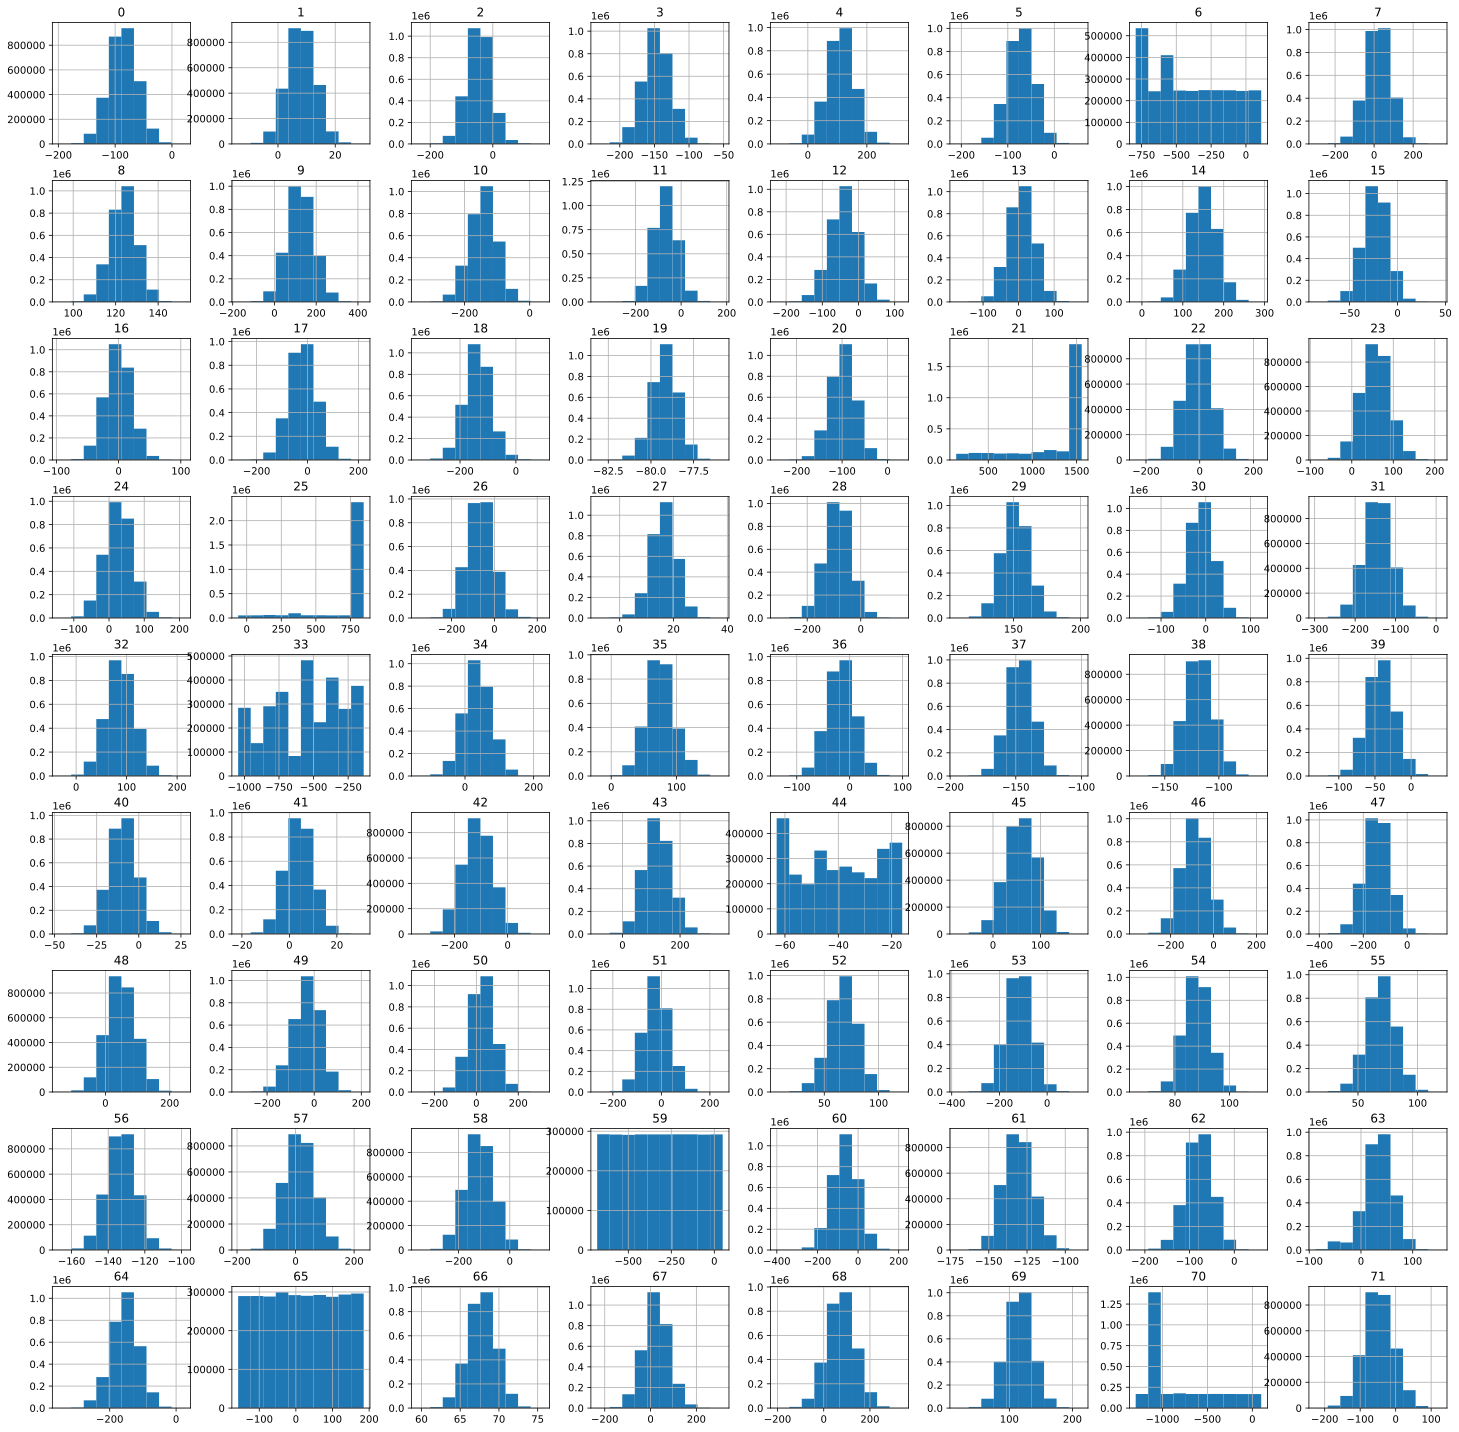

In [12]:
df_base.hist(figsize=(25, 25));

**Вывод**  
В результате анализа датасета с 72 колонками и 291813 строками были получены следующие ключевые моменты:

- Дубликаты: Не обнаружены
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти.
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.

## Посмотрим данные в столбце df_train

In [13]:
preprocessing(df_train)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.883,17.971,-42.117,-183.937,187.517,-87.145,-347.361,38.308,109.086,30.414,-88.083,-52.696,-27.692,4.873,198.348,-30.075,-3.804,-135.811,-161.841,-78.512,-94.429,898.437,-70.141,78.420,108.033,...,6.622,-132.198,68.713,-38.807,62.937,-132.654,89.189,87.040,-121.280,-6.987,-206.514,29.486,-77.030,-132.386,-105.428,70.107,-155.803,-101.966,65.904,34.458,62.642,134.764,-415.750,-25.959,675816-base
1-query,-87.776,6.806,-32.055,-177.260,120.803,-83.811,-94.573,-78.433,124.916,140.331,-177.606,-84.996,42.811,-57.256,96.793,-19.261,0.740,50.619,-155.267,-78.659,-92.761,353.158,-34.745,82.487,-28.451,...,37.450,-23.299,74.061,-7.140,75.862,-112.045,82.858,54.067,-134.005,-26.143,-214.632,-457.848,21.460,-137.411,-40.812,4.669,-151.698,-1.639,68.171,25.096,89.975,130.590,-1035.092,-51.277,366656-base
2-query,-49.980,3.841,-116.119,-180.402,190.128,-50.838,26.944,-30.447,125.771,211.608,-86.347,-35.667,16.395,-80.803,137.909,-23.533,-47.257,-16.650,-194.506,-78.373,-69.324,1507.231,-52.501,-34.166,52.959,...,53.462,-31.117,107.842,16.483,77.934,-95.619,91.460,63.120,-126.939,8.067,-195.678,-163.120,-72.830,-139.223,-52.032,78.040,-169.146,82.144,66.008,18.400,212.410,121.931,-1074.465,-22.547,1447819-base
3-query,-47.811,9.087,-115.402,-121.011,94.653,-109.255,-775.150,79.187,124.003,242.651,-146.517,-159.470,-13.845,-6.114,118.939,-44.586,9.559,14.436,-156.907,-78.789,-78.737,1507.231,19.957,34.834,-8.821,...,71.241,-168.116,118.236,-18.065,37.256,-137.691,87.501,62.437,-131.261,35.693,-86.039,-379.339,-153.466,-131.198,-61.567,44.515,-145.417,93.991,64.131,106.062,83.179,118.278,-1074.465,-19.903,1472602-base
4-query,-79.632,14.443,-58.903,-147.053,57.127,-16.240,-321.318,45.985,125.941,103.393,-107.153,-8.800,-50.978,29.457,143.389,5.615,-45.275,9.644,-77.555,-79.067,-77.926,1507.231,16.612,116.284,33.755,...,79.796,46.763,47.682,-24.104,75.143,-207.345,93.437,51.505,-135.476,99.804,-49.158,-203.213,-127.748,-103.342,-68.771,45.029,-196.092,-117.626,66.926,42.456,77.622,92.480,-1074.465,-21.149,717819-base


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (100000, 73)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,...,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,-85.329,7.664,-43.667,-146.119,111.771,-73.179,-440.615,21.232,123.068,126.120,-141.169,-69.228,-42.560,6.507,149.078,-23.942,-2.219,-12.964,-138.715,-79.160,-97.475,1297.270,-3.601,55.908,23.470,...,-140.788,46.138,-34.137,29.463,-22.343,67.581,-120.053,88.194,69.539,-132.337,14.453,-120.302,-315.282,-66.379,-130.672,-81.146,36.898,-152.223,14.002,67.800,23.029,73.412,115.190,-709.762,-48.506
std,25.804,4.956,39.111,20.435,47.701,28.719,279.018,65.985,6.492,64.913,41.608,51.259,40.820,37.594,34.168,13.024,20.979,55.211,48.737,0.776,28.382,375.124,50.064,35.618,40.803,...,59.851,46.328,59.325,60.935,54.992,12.988,55.921,4.824,12.340,7.952,49.235,55.730,210.658,64.913,9.408,30.676,25.358,41.020,99.080,1.838,55.471,62.203,21.582,405.961,41.215
min,-186.280,-11.561,-224.896,-223.307,-93.272,-184.962,-791.469,-278.583,94.831,-142.157,-330.571,-352.405,-214.742,-145.860,8.818,-82.645,-91.657,-247.589,-326.649,-82.637,-228.808,136.873,-211.972,-87.324,-122.584,...,-365.061,-129.879,-280.372,-250.338,-236.148,18.477,-354.916,66.069,18.105,-161.189,-183.850,-330.638,-681.029,-358.460,-169.566,-210.059,-60.779,-317.832,-157.590,60.669,-203.746,-181.974,22.599,-1297.872,-209.936
25%,-103.309,4.314,-69.494,-160.029,79.474,-92.834,-738.537,-22.132,118.675,82.545,-168.599,-103.049,-69.802,-18.815,126.369,-32.380,-16.456,-49.612,-171.661,-79.657,-115.408,1248.126,-37.048,31.437,-5.051,...,-181.176,14.323,-73.415,-11.034,-59.606,58.554,-157.930,84.912,61.211,-137.752,-19.538,-158.719,-497.153,-110.071,-137.070,-101.505,19.775,-178.929,-71.745,66.561,-14.145,31.686,100.589,-1074.465,-76.479
50%,-85.274,7.653,-42.830,-146.067,112.260,-73.364,-511.838,22.279,123.088,125.963,-140.461,-68.753,-41.920,6.739,149.706,-23.707,-2.339,-12.190,-139.009,-79.137,-96.863,1507.231,-3.609,55.274,23.307,...,-140.504,45.500,-31.942,30.275,-23.291,67.261,-120.104,88.187,69.655,-132.256,13.611,-120.229,-315.177,-65.255,-130.804,-80.860,36.711,-151.577,14.073,67.814,23.441,72.880,115.237,-808.802,-48.701
75%,-67.331,10.981,-17.714,-132.278,143.761,-53.700,-201.117,65.900,127.542,169.701,-113.137,-34.669,-14.631,32.075,172.627,-15.438,11.703,24.465,-106.747,-78.639,-78.584,1507.231,29.473,79.558,51.787,...,-100.564,77.579,6.814,70.795,14.650,76.497,-81.456,91.454,77.978,-126.865,48.040,-81.685,-132.410,-21.825,-124.460,-60.492,53.920,-124.437,100.011,69.059,59.941,114.469,129.791,-357.087,-20.488
max,14.585,28.918,128.108,-60.752,301.364,51.850,109.625,288.172,149.356,392.827,37.017,152.500,116.210,171.127,279.153,35.553,94.325,215.488,79.245,-75.836,26.484,1557.383,193.884,207.021,199.462,...,110.090,232.166,191.037,257.152,212.169,121.796,111.493,107.388,116.728,-99.661,193.693,107.606,48.724,189.176,-92.037,47.733,145.667,11.907,185.095,74.780,266.493,319.868,201.761,98.768,126.192


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,95977
1,96116
2,96174
3,95373
4,96049
...,...
68,96169
69,95760
70,70820
71,96150


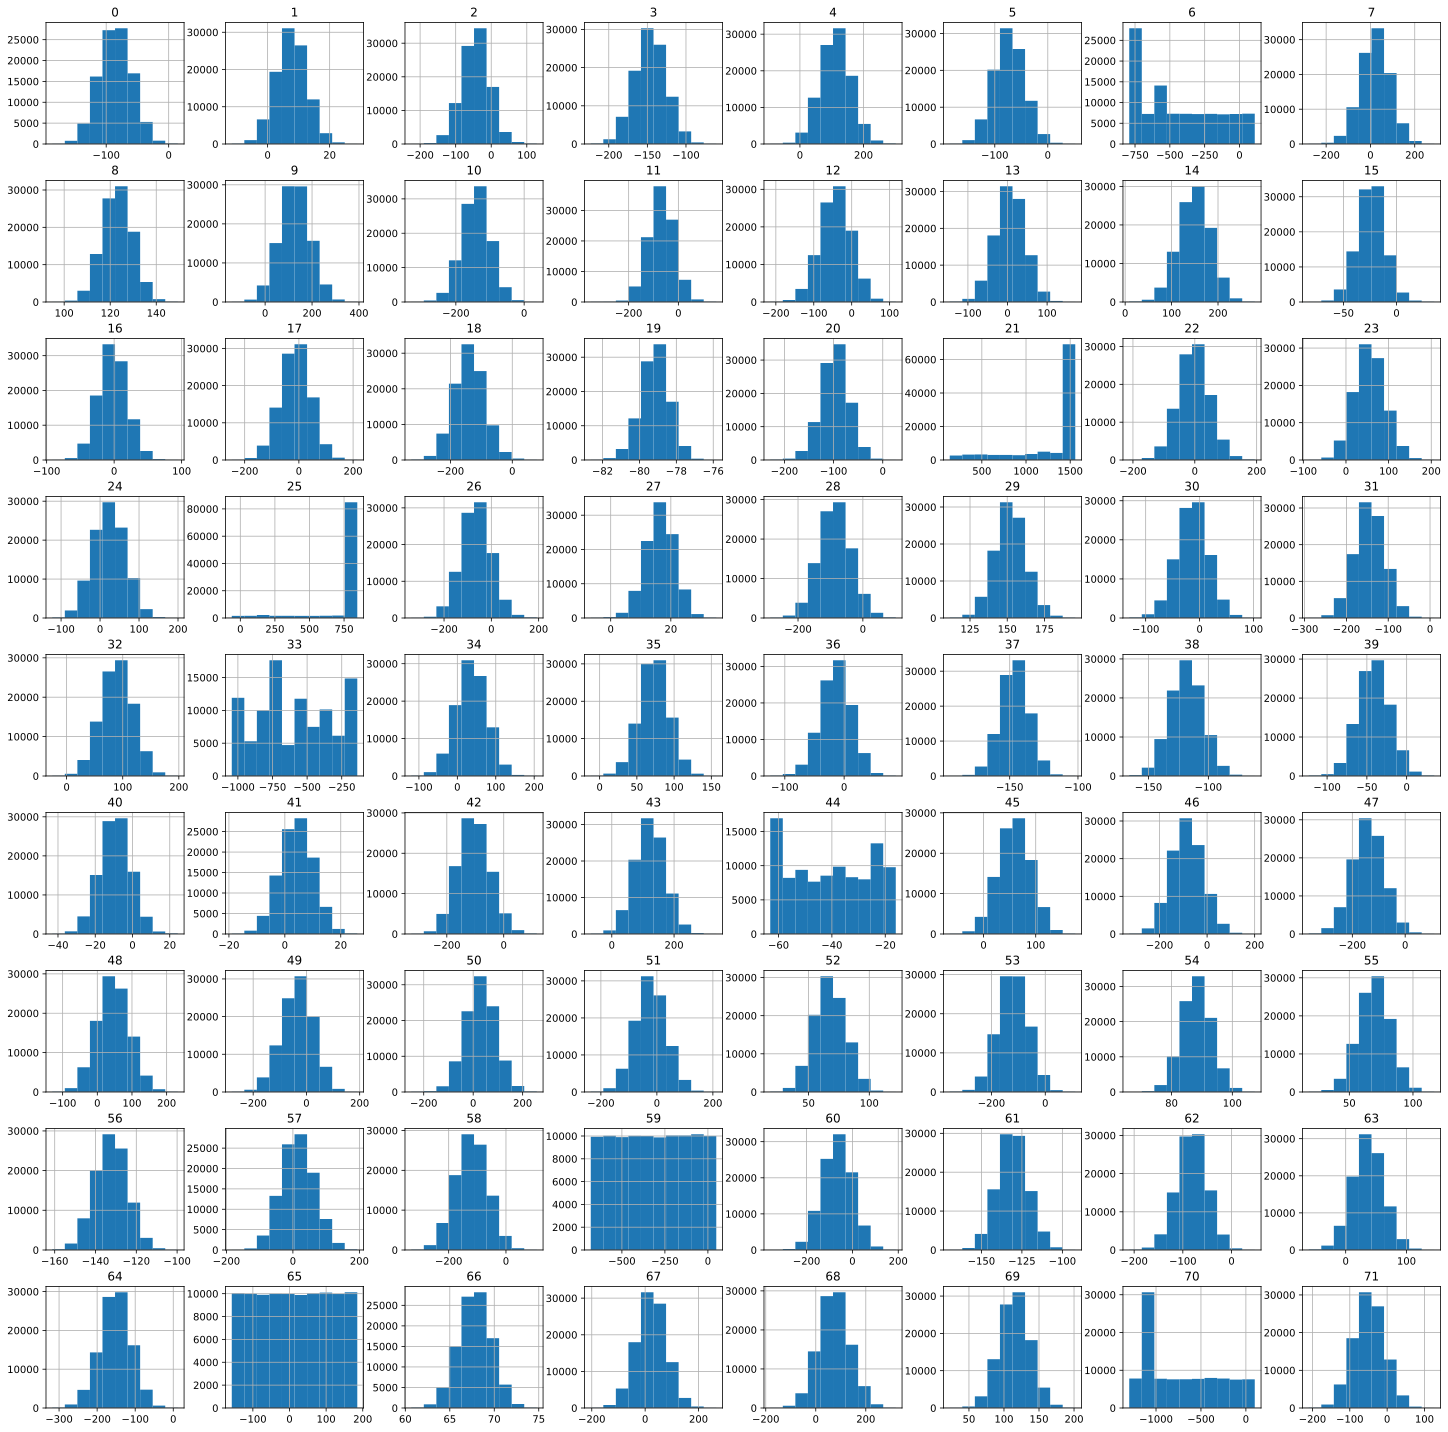

In [14]:
df_train.hist(figsize=(25, 25));

**Вывод**
В результате анализа датасета с 73 колонками и 999 999 строками были получены следующие ключевые моменты:

- Дубликаты: Не обнаружено
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти. Есть не числовой столбец tsrget содержащий наш целевой признак
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. (как и в общей базе) Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.




## Посмотрим на df_validation

In [15]:
preprocessing(df_validation)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.373,3.598,-13.214,-125.927,110.746,-81.280,-461.003,139.816,112.881,75.216,-131.893,-140.969,-57.987,-22.869,150.896,7.966,17.622,-34.868,-216.139,-80.909,-52.580,263.363,56.267,66.925,21.610,...,-143.656,-4.260,-46.664,-27.085,-34.347,75.530,-47.172,92.697,60.476,-127.487,-39.485,-124.385,-307.950,45.507,-144.191,-75.513,52.831,-143.439,59.052,69.282,61.928,111.593,115.141,-1099.130,-117.079
100001-query,-53.759,12.790,-43.269,-134.418,114.450,-90.520,-759.626,63.995,127.118,53.129,-153.717,-63.951,-52.369,-33.391,148.620,-22.484,15.164,-56.202,-153.614,-79.832,-101.055,1203.537,81.597,101.019,56.783,...,-259.636,52.438,-30.005,14.502,-1.071,66.843,-161.280,94.794,50.420,-125.075,-25.169,-176.177,-655.837,-99.238,-141.535,-79.442,29.185,-168.606,-82.872,70.766,-65.976,97.077,123.392,-744.442,-25.009
100002-query,-64.175,-3.981,-7.679,-170.161,96.446,-62.378,-759.626,87.478,131.270,168.920,-220.310,-31.378,-8.789,2.285,133.266,-41.309,14.306,-18.232,-205.534,-78.160,-96.608,1507.231,-5.964,34.937,-56.087,...,-162.616,117.128,13.079,69.827,-6.874,63.707,-123.851,91.611,59.760,-129.566,-12.822,-154.198,-407.199,5.523,-126.813,-134.795,37.369,-159.662,-119.233,67.710,86.002,137.636,141.082,-294.052,-70.970
100003-query,-99.287,16.124,9.837,-148.060,83.697,-133.730,58.576,-19.047,115.042,75.207,-114.272,-71.406,-65.349,24.377,50.467,-14.721,15.069,-46.683,-176.604,-78.691,-139.227,325.547,3.632,74.930,-4.802,...,-141.523,60.217,73.386,118.568,58.901,55.569,-181.092,83.340,66.083,-114.049,-57.157,-56.335,-318.680,-15.985,-128.101,-77.236,44.100,-132.530,-106.319,70.884,23.578,133.184,143.253,-799.364,-89.393
100004-query,-79.533,-0.364,-16.027,-170.885,165.454,-28.292,33.932,34.411,128.904,102.087,-76.214,-26.394,34.424,50.939,157.683,-23.786,-33.175,-0.593,-193.319,-79.651,-91.890,1358.481,44.028,121.527,46.183,...,-175.657,25.395,47.875,51.465,140.952,58.751,-215.488,91.255,44.165,-135.295,-19.508,-106.675,-127.979,-11.433,-135.570,-123.770,45.636,-134.259,13.735,70.618,15.332,154.568,101.701,-1171.892,-125.308


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (100000, 72)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,...,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000,100000.000
mean,-85.302,7.670,-43.842,-146.120,111.635,-73.273,-441.397,21.594,123.078,126.001,-141.215,-69.340,-42.627,6.272,149.006,-23.962,-2.010,-13.151,-138.541,-79.163,-97.356,1301.395,-3.440,56.098,23.357,...,-141.003,46.188,-34.154,29.405,-22.543,67.486,-120.308,88.175,69.496,-132.377,14.412,-120.382,-316.402,-66.615,-130.653,-81.129,36.779,-152.341,14.398,67.789,23.251,73.114,115.197,-709.457,-48.416
std,25.777,4.957,39.139,20.496,47.752,28.516,279.243,66.478,6.505,64.982,41.568,51.483,40.858,37.846,34.032,13.015,20.994,55.340,48.790,0.777,28.504,371.544,50.291,35.600,40.850,...,59.595,45.997,59.612,60.943,55.140,13.036,56.108,4.809,12.324,7.895,49.387,55.818,211.131,65.195,9.427,30.692,25.427,41.246,98.695,1.845,55.404,62.056,21.493,405.666,41.293
min,-190.353,-11.110,-217.538,-220.051,-81.199,-176.705,-791.460,-265.608,96.218,-135.667,-321.544,-363.493,-204.299,-144.101,-14.816,-78.597,-86.843,-272.566,-329.860,-82.665,-231.377,136.846,-208.901,-84.225,-138.217,...,-375.452,-121.268,-277.376,-279.886,-234.521,12.405,-381.609,65.986,17.302,-162.873,-156.582,-329.701,-681.038,-339.966,-168.736,-215.152,-66.266,-337.633,-157.594,60.378,-210.673,-175.922,25.271,-1297.924,-209.936
25%,-103.232,4.292,-69.681,-160.210,79.102,-92.790,-740.620,-21.805,118.658,82.311,-168.563,-103.338,-70.147,-19.089,126.442,-32.357,-16.392,-49.942,-171.696,-79.665,-115.390,1248.126,-36.892,31.742,-5.265,...,-180.876,14.916,-73.758,-10.882,-59.953,58.412,-158.217,84.887,61.296,-137.751,-20.102,-158.848,-499.828,-110.385,-137.093,-101.690,19.564,-179.115,-70.420,66.546,-13.863,31.495,100.539,-1074.465,-76.359
50%,-85.297,7.658,-43.231,-146.080,111.959,-73.579,-513.923,22.138,123.063,126.084,-140.410,-68.619,-42.192,6.420,149.639,-23.758,-2.076,-12.402,-139.001,-79.140,-96.694,1507.231,-3.387,55.461,23.120,...,-140.933,45.577,-32.078,30.385,-23.197,67.173,-120.326,88.150,69.585,-132.322,13.510,-120.457,-317.215,-65.756,-130.753,-81.027,36.414,-151.426,14.768,67.800,23.509,72.152,115.281,-807.030,-48.670
75%,-67.422,10.994,-17.766,-132.119,143.904,-53.861,-202.572,66.098,127.539,169.680,-113.317,-34.845,-14.725,31.930,172.417,-15.464,11.972,24.229,-106.608,-78.636,-78.378,1507.231,29.878,79.815,51.817,...,-101.452,77.263,7.037,70.646,14.739,76.403,-81.607,91.401,77.933,-126.956,47.903,-81.473,-132.569,-21.913,-124.387,-60.275,53.888,-124.400,99.804,69.041,60.155,114.317,129.770,-358.400,-20.283
max,14.428,27.410,134.860,-57.382,302.065,50.255,109.632,279.469,151.823,392.827,34.505,170.344,120.532,177.762,277.418,36.472,92.662,197.927,82.684,-76.178,9.297,1557.293,194.322,203.892,198.850,...,114.079,228.379,178.697,259.979,186.125,123.390,115.465,108.947,116.728,-99.840,206.817,102.781,48.722,194.324,-93.943,41.390,141.025,14.602,185.094,75.400,251.289,305.938,201.600,98.737,111.832


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



0

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,95989
1,96187
2,96204
3,95462
4,96102
...,...
67,96244
68,96195
69,95790
70,70511


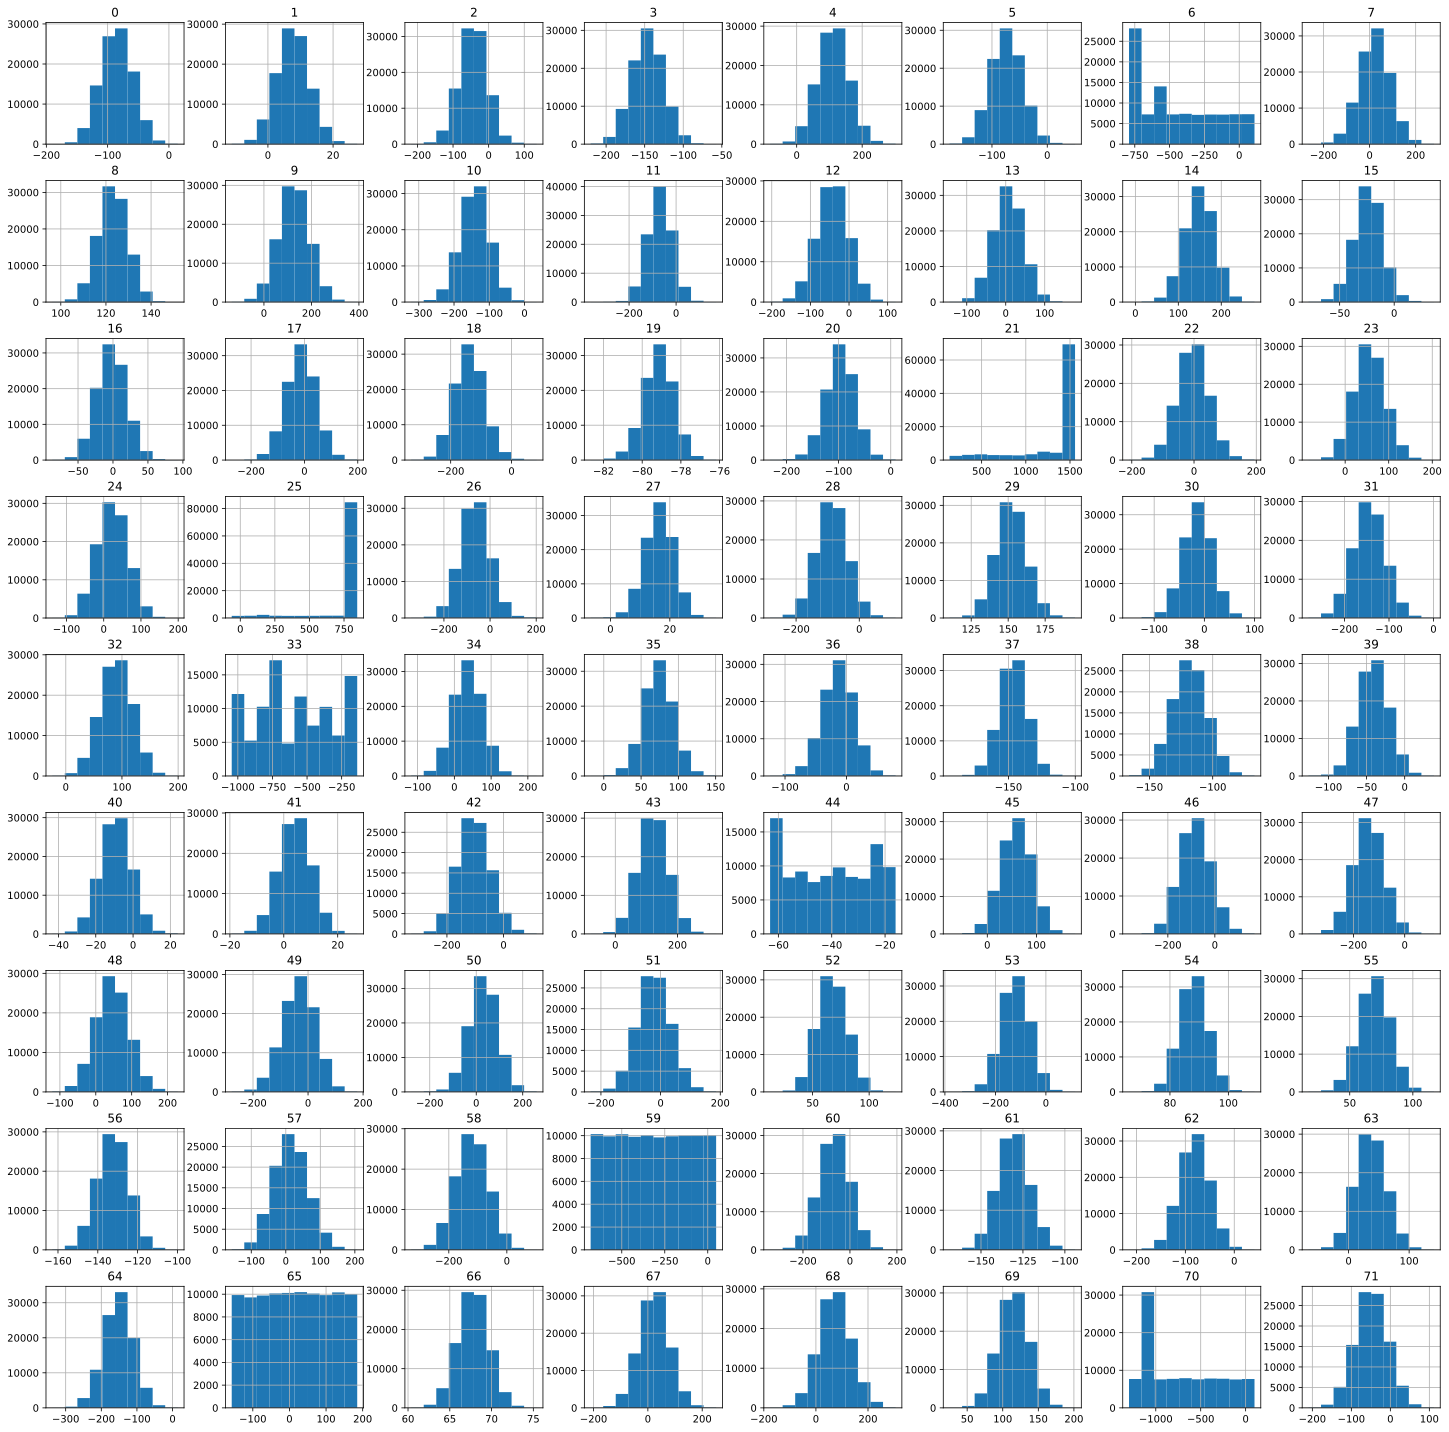

In [16]:
df_validation.hist(figsize=(25, 25));

**Вывод**
В результате анализа датасета с 72 колонками и 10 000 строками были получены следующие ключевые моменты:

- Дубликаты: Обнаружено 265 дубликатов. Рекомендуется провести их удаление для повышения качества анализа и моделирования.
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти.
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. (как и в общей базе) Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.

## Посмотрим на df_validation_answer


In [17]:
preprocessing(df_validation_answer)

Изучение данных датафрейма
Вывод первых 5 строк 



,expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (100000, 1)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,expected
count,100000
unique,91502
top,210304-base
freq,7


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



8498

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
expected,91502


Это наша контрольная таблица, содержит столько же значений что и df_validation, поэтому удалять дубликаты не будем, всегда же может быть что нужно найти пары к одному и тому же товару, ну а ответы конечно могут содержать похожие товары

## Предобработка


Проведем ее так же для полной и сокращенной выборки (сокращенная нам нужна для тестирования алгоритма, и должна быть предобработана аналогично полной)

In [18]:
def preprocess_data(df, drop_duplicates=True):
    # Проверка на дубликаты
    if drop_duplicates:
        # Подсчет количества дубликатов до их удаления
        num_duplicates_before = df.duplicated().sum()
        if num_duplicates_before > 0:
            print(f"Обнаружено {num_duplicates_before} дубликатов. Они будут удалены.")
            df = df.drop_duplicates()
            # Подсчет количества дубликатов после удаления
            num_duplicates_after = df.duplicated().sum()
            if num_duplicates_after == 0:
                print("Дубликаты успешно удалены.")
            else:
                print(f"После удаления осталось {num_duplicates_after} дубликатов.")
        else:
            print("Дубликаты не обнаружены.")
    return df

In [19]:
# Предобработка наборов данных
df_base = preprocess_data(df_base)
df_train = preprocess_data(df_train)
df_validation = preprocess_data(df_validation, drop_duplicates=False)  # Не удаляем дубликаты
df_validation_answer = preprocess_data(
    df_validation_answer, drop_duplicates=False
)  # Не удаляем дубликаты

Дубликаты не обнаружены.
Дубликаты не обнаружены.


In [20]:
# Предобработка наборов данных
df_base_short = preprocess_data(df_base_short)
df_train_short = preprocess_data(df_train_short)
df_validation_short = preprocess_data(
    df_validation_short, drop_duplicates=False
)  # Не удаляем дубликаты
df_validation_answer_short = preprocess_data(
    df_validation_answer_short, drop_duplicates=False
)  # Не удаляем дубликаты

Обнаружено 11278 дубликатов. Они будут удалены.
Дубликаты успешно удалены.
Обнаружено 243 дубликатов. Они будут удалены.
Дубликаты успешно удалены.


### Стандартизация

Так как признаки в нашем датасете находятся в разных диапазонах , это может привести к тому, что алгоритм будет неправильно интерпретировать расстояния между точками.   
В дальнейшем нужно провести поиск ближайших соседей на основе рассчета растояний между векторами, следоательно нам нужно использовать `StandardScaler`, и с помощью него провести стандартизацию признаков - стандартизация приводит все признаки к единой шкале (среднее 0 и стандартное отклонение 1), что делает расстояния между точками более объективными и корректными.

In [21]:
def standardize_data(df):
    # Получение числовых столбцов
    numerical_cols = df.select_dtypes(include=["float64", "float32", "int", "int64"]).columns
    scaler = StandardScaler()

    # Проверка, есть ли числовые столбцы для стандартизации
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

        # Проверка успешности стандартизации
        max_mean_deviation = df[numerical_cols].mean().abs().max()
        max_std_deviation = (df[numerical_cols].std() - 1).abs().max()
        if max_mean_deviation < 0.1 and max_std_deviation < 0.1:
            print("Стандартизация прошла успешно.")
        else:
            print("Стандартизация не удалась.")
    else:
        print("Нет числовых столбцов для стандартизации.")

    return df

Делаем стандартизацию так же для полного и сокращенного датасета

In [22]:
# Стандартизация
df_base = standardize_data(df_base)
df_train = standardize_data(df_train)
df_validation = standardize_data(df_validation)
# Стандартизация сокращенной базы
df_base_short = standardize_data(df_base_short)
df_train_short = standardize_data(df_train_short)
df_validation_short = standardize_data(df_validation_short)

Стандартизация прошла успешно.
Стандартизация прошла успешно.
Стандартизация прошла успешно.
Стандартизация прошла успешно.
Стандартизация прошла успешно.
Стандартизация прошла успешно.


In [23]:
# Удаление колонок с отклонениями из полной
columns_to_remove = [6, 21, 25, 33, 44, 59, 65, 70]
df_base.drop(columns=df_base.columns[columns_to_remove], inplace=True)
df_train.drop(columns=df_train.columns[columns_to_remove], inplace=True)
df_validation.drop(columns=df_validation.columns[columns_to_remove], inplace=True)
# Удаление колонок с отклонениями из сокращенной
df_base_short.drop(columns=df_base_short.columns[columns_to_remove], inplace=True)
df_train_short.drop(columns=df_train_short.columns[columns_to_remove], inplace=True)
df_validation_short.drop(columns=df_validation_short.columns[columns_to_remove], inplace=True)

In [24]:
# Вывод размера предобработанных данных
print(f"df_base shape: {df_base.shape}")
print(f"df_train shape: {df_train.shape}")
print(f"df_validation shape: {df_validation.shape}")
print(f"df_validation_answer shape: {df_validation_answer.shape}")

# Вывод размера предобработанных данных сокращенной базы
print(f"df_base_short shape: {df_base_short.shape}")
print(f"df_train_short shape: {df_train_short.shape}")
print(f"df_validation_short shape: {df_validation_short.shape}")
print(f"df_validation_answer_short shape: {df_validation_answer_short.shape}")

df_base shape: (2918139, 64)
df_train shape: (100000, 65)
df_validation shape: (100000, 64)
df_validation_answer shape: (100000, 1)
df_base_short shape: (280535, 64)
df_train_short shape: (9756, 65)
df_validation_short shape: (10000, 64)
df_validation_answer_short shape: (10000, 1)


## Настройка алгоритма

**Предобработка завершена, данные стандартизированы, столбцы выбивающиеся из нормального распределения удалены можно приступать к настройке алгоритма**  
Проведем его на сокращенной базе

`Faiss (Facebook AI Similarity Search)` — это библиотека для эффективного поиска похожих векторов в больших наборах данных. Она была разработана в Facebook для обработки огромных объемов данных, таких как изображения или тексты, где необходимо быстро находить близкие векторы по метрике сходства

**Как работает Faiss:**
- Индексация данных: В начале необходимо индексировать набор данных. Faiss создает структуру данных, которая быстро позволяет находить близкие векторы к запросам.

- Поиск похожих векторов: Когда данные проиндексированы, Faiss позволяет выполнять запросы для поиска близких векторов к заданному запросу. Можно указать количество ближайших соседей, которые нужно найти, и Faiss вернет наиболее близкие векторы по выбранной метрике расстояния.

- Оптимизация производительности: Faiss оптимизирован для работы с большими объемами данных и предлагает эффективные алгоритмы для ускорения операций поиска, включая использование GPU и специализированные структуры данных.

Свою работу выполняю на Mac OS, поэтому использую CPU (На CPU доступны те же алгоритмы индексации, что и на GPU, включая IndexFlatL2, IndexIVFFlat, IndexIVFPQ)

`IndexFlatL2` является одним из самых простых и прямолинейных индексов в Faiss, который использует L2 (евклидово) расстояние для поиска ближайших соседей.  
Этот индекс не использует структурированные индексы или квантование, что делает его подходящим для небольших наборов данных или когда требуется высокая точность.

Мы будем использовать `**IndexIVFFlat**  `  
IndexIVFFlat является более сложным и эффективным индексом в Faiss, предназначенным для работы с большими наборами данных. Он использует инвертированные файлы (Inverted File Lists, IVF) для ускорения поиска ближайших соседей, разбивая пространство векторов на кластеры и выполняя поиск только в наиболее релевантных кластерах.

Данный индекс нам наиболее подходит ввиду большой базы данных

Для инициализации IndexIVFFlat необходимо использовать квантователь типа IndexFlatL2.   
Это связано с тем, что IndexFlatL2 является простым индексом, который будет использоваться для создания кластеров при тренировке IndexIVFFlat.

Квантователь (quantizer) — это индекс, который используется для разбиения пространства векторов на кластеры. В основном, квантователь помогает разделить большое количество векторов на меньшие подмножества, что позволяет существенно ускорить процесс поиска ближайших соседей.   
IndexFlatL2 используется как квантователь для IndexIVFFlat, чтобы создать кластеры на основе евклидова расстояния.

После создания и тренировки кластеров, основной индекс IndexIVFFlat будет использовать эти кластеры для быстрого поиска ближайших соседей.

**Важный момент**

Для тренировки алгоритма, нужно определиться с тем сколько у нас будет кластеров, и определить в скольки кластерах наш алгоритм будет искать ближайших соседей. При 1 алгоритм ищет только в одном кластере, при большем количестве поиск идет в большем количестве кластеров, увеличивая время поиска, но и повышает точность.
Выбор оптимального значения nprobe зависит от компромисса между точностью и производительностью.

https://www.geeksforgeeks.org/determining-the-number-of-clusters-in-data-mining/ говорит, что оптимально взять  значение примерно $$\sqrt{\frac{n}{2}}$$ для набора данных из n точек
> A simple method to calculate the number of clusters is to set the value to about √(n/2)$$\sqrt{\frac{n}{2}}$$ for a dataset of ‘n’ points.

Однако, код у меня завис с таки большим количеством кластеров, в связи с чем, возьму пока небольшое значение в 20 (оно указано в примере приложенном в мастерской), и проведем поиск по 5 кластерам https://github.com/facebookresearch/faiss/wiki/Faiss-indexes документация говорит о том что чем больше поиск по кластерам тем точнее, в одном из примеров было указано значение 5, его и возьмем для nprobe


Далее планирую использовать метод локтя: для выбора оптимального количества кластеров.   
Для этого оценим внутреннюю метрику, такую как внутрикластерное расстояние, и выберем количество кластеров на "локте" графика.

In [56]:
# Определение размерности признаков (число столбцов в df_base_short).
dims = df_base_short.shape[1]

https://machinelearningapplied.com/fast-gpu-based-nearest-neighbors-with-faiss/
Воспользовалась подсказкой что
> для при использовании массивов Numpy в качестве входных данных для них должно быть задано значение dtype = ‘float32’. Faiss предполагает, что массивы Numpy являются непрерывными. Воспользуйся: ny_array = np.ascontiguousarray(npy_array)

In [57]:
# Основные данные (df_base_short) приводим к float32
base_features = np.ascontiguousarray(df_base_short.values).astype("float32")

In [58]:
# Подготовка данных для обучения и извлечение целевых значений
targets = df_train_short["target"].values
df_train_features = df_train_short.drop(["target"], axis=1)
train_features = np.ascontiguousarray(df_train_features.values).astype("float32")

In [59]:
# Создание словаря индексов
base_index = dict(enumerate(df_base_short.index.to_list()))

Определение диапазона значений для n_cells методом локтя

In [60]:
# Диапазон значений для n_cells
n_cells_range = range(5, 201, 5)
candidate_number = 5  # Количество ближайших соседей для поиска
accuracies = []

В цикле для каждого значения n_cell которое мы выбрали от 5 до 50 с шагом 5, происходит
- Инициализация квантователя faiss.IndexFlatL2.
- Создание индекса faiss.IndexIVFFlat с текущим n_cells для шага цикла.
- Установка параметра nprobe, определяющего количество кластеров для поиска (у нас он задан в 5 кластеров).
- Тренировка индекса на данных base_features_short.
- Добавление данных base_features_short в индекс.
- Поиск ближайших соседей для train_features_short.
- Оценка точности: подсчет количества случаев, когда целевой индекс присутствует среди ближайших соседей.
- Сохранение и вывод текущей точности.

In [61]:
for n_cells in n_cells_range:
    # Инициализация квантователя с L2-нормой и создание индекса
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.nprobe = 3

    # Обучение индекса
    idx_l2.train(base_features)
    idx_l2.add(base_features)

    # Поиск ближайших соседей
    distances, indices = idx_l2.search(train_features, candidate_number)

    # Оценка точности
    acc = 0
    for target, neighbors in zip(targets, indices):
        acc += int(target in [base_index[r] for r in neighbors])

    accuracy = 100 * acc / len(indices)
    accuracies.append(accuracy)
    print(f"n_cells: {n_cells}, Accuracy: {accuracy:.2f}%")

n_cells: 5, Accuracy: 78.21%
n_cells: 10, Accuracy: 77.32%
n_cells: 15, Accuracy: 76.65%
n_cells: 20, Accuracy: 76.51%
n_cells: 25, Accuracy: 76.07%
n_cells: 30, Accuracy: 76.01%
n_cells: 35, Accuracy: 75.68%
n_cells: 40, Accuracy: 75.49%
n_cells: 45, Accuracy: 75.80%
n_cells: 50, Accuracy: 75.13%
n_cells: 55, Accuracy: 75.17%
n_cells: 60, Accuracy: 75.27%
n_cells: 65, Accuracy: 75.09%
n_cells: 70, Accuracy: 75.21%
n_cells: 75, Accuracy: 75.29%
n_cells: 80, Accuracy: 75.51%
n_cells: 85, Accuracy: 74.93%
n_cells: 90, Accuracy: 75.34%
n_cells: 95, Accuracy: 74.94%
n_cells: 100, Accuracy: 75.26%
n_cells: 105, Accuracy: 74.93%
n_cells: 110, Accuracy: 74.79%
n_cells: 115, Accuracy: 75.03%
n_cells: 120, Accuracy: 74.87%
n_cells: 125, Accuracy: 74.90%
n_cells: 130, Accuracy: 74.83%
n_cells: 135, Accuracy: 74.90%
n_cells: 140, Accuracy: 74.83%
n_cells: 145, Accuracy: 74.95%
n_cells: 150, Accuracy: 74.86%
n_cells: 155, Accuracy: 74.61%
n_cells: 160, Accuracy: 74.93%
n_cells: 165, Accuracy: 74.7

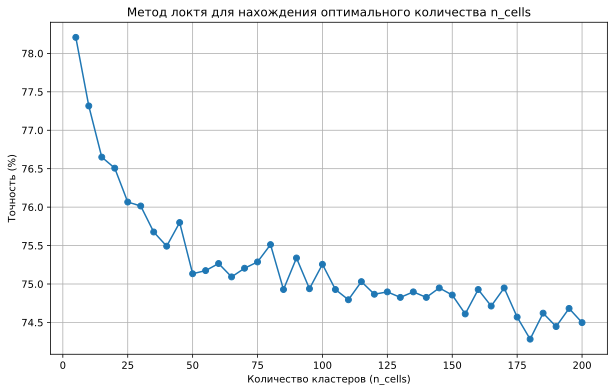

In [32]:
# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(n_cells_range, accuracies, marker="o", linestyle="-")
plt.xlabel("Количество кластеров (n_cells)")
plt.ylabel("Точность (%)")
plt.title("Метод локтя для нахождения оптимального количества n_cells")
plt.grid(True)
plt.show()

Метод локтя — инструмент анализа данных, направленный на оптимизацию числа кластеров в алгоритмах кластеризации.
Анализ графика
Резкое снижение: Начальные точки (например, от n_cells = 5 до n_cells = 30) показывают более резкое снижение точности.
Замедление снижения: Начиная примерно с n_cells = 35 и далее, точность снижается более плавно и незначительно.
Таким образом, "локоть" находится примерно в диапазоне от n_cells = 30 до n_cells = 40. Это означает, что для нашей задачи значение n_cells в этом диапазоне может быть оптимальным, обеспечивая баланс между достаточной точностью и эффективностью кластеризации. Возьмем  - 30

In [34]:
# Тренировка алгоритма на лучшем значении n_cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, 30)
idx_l2.nprobe = 3

# Обучение индекса на всех данных
idx_l2.train(base_features)
idx_l2.add(base_features)

# Поиск ближайших соседей на тренировочных данных
distances, indices = idx_l2.search(train_features, candidate_number)

# Оценка точности на тренировочных данных
acc = 0
for target, neighbors in zip(targets, indices):
    acc += int(target in [base_index[r] for r in neighbors])

accuracy = 100 * acc / len(indices)
print(f"Точность на тренировочных данных с лучшим n_cells ({30}): {accuracy:.2f}%")

Точность на тренировочных данных с лучшим n_cells (30): 76.01%


**Теперь проверим работу алгоритма на df_validation_short и сравним их с ответами в df_validation_answer_short**

Поиск соседей: Используется метод `search` индекса `idx_l2` для поиска пяти ближайших соседей векторов из `df_validation` в данных из `df_base`. Результат включает расстояния до соседей `(r_val)` и индексы соседей `(idx_val)`. Векторы преобразуются в формат float32.

In [35]:
# Поиск пяти индексов (пяти соседей) для validation из base
r_val, idx_val = idx_l2.search(
    np.ascontiguousarray(df_validation_short.values).astype("float32"), 5
)

In [36]:
# Выводим на экран индексы пяти ближайших соседей из base для каждого товара validation
print("Индексы пяти ближайших соседей:")
idx_val

Индексы пяти ближайших соседей:


array([[ 46202, 242163,  68425, 272031, 198388],
       [  3786, 181149,  63279, 105570, 157572],
       [ 54931, 126599,  97207, 257601,  10671],
       ...,
       [ 65791,  74434, 165218, 188250, 238357],
       [138211,  19848, 251214, 115030,  89556],
       [149533,  46020, 160926, 265594, 123736]])

Для получения правильных ответов достанем столбец "expected" из df_validation_answer_short, который содержит правильные ответы для валидационных данных. Эти значения сохраним в массив `targets_valid_short`.

In [37]:
# Извлекаем правильные ответы из df_valid_answer
targets_valid_short = df_validation_answer_short["expected"].values

In [38]:
targets_valid_short

array(['1087368-base', '849674-base', '4183486-base', ..., '3821-base',
       '18068-base', '1197661-base'], dtype=object)

Подготовим счетчик: Переменная acc используется для подсчета количества правильных предсказаний. Затем создается словарь base_index, который сопоставляет индекс DataFrame df_base с его позициями для более легкого поиска.

In [39]:
acc = 0
base_index = dict(enumerate(df_base_short.index.to_list()))

In [40]:
for target, neighbors in zip(targets_valid_short, idx_val):
    acc += any(target == base_index[row] for row in neighbors)

In [41]:
# Выводим точность
accuracy = 100 * acc / len(idx_val)
print(f"Accuracy на валидации: {accuracy:.2f}%")

Accuracy на валидации: 75.19%


Получили вполне неплохую метрику на сокращенном дата сете, попробуем обучить алгоритм на полном, мы уже знаем оптимальное количество кластеров, осталось только применить алгоритм

In [42]:
# Определение размерности признаков (число столбцов в df_base_short).
dims = df_base.shape[1]

In [43]:
# Основные данные (df_base) приводим к float32
base_features = np.ascontiguousarray(df_base.values).astype("float32")

In [44]:
# Подготовка данных для обучения и извлечение целевых значений
targets = df_train["target"].values
df_train_features = df_train.drop(["target"], axis=1)
train_features = np.ascontiguousarray(df_train_features.values).astype("float32")

In [45]:
# Создание словаря индексов
base_index = dict(enumerate(df_base.index.to_list()))

In [46]:
# Тренировка алгоритма на лучшем значении n_cells
quantizer = faiss.IndexFlatL2(dims)
n_cells = 30
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
idx_l2.nprobe = 3

In [47]:
# Обучение индекса на всех данных
idx_l2.train(base_features)
idx_l2.add(base_features)

In [48]:
# Поиск ближайших соседей на тренировочных данных
distances, indices = idx_l2.search(train_features, candidate_number)

In [50]:
# Оценка точности на тренировочных данных
acc = 0
for target, neighbors in zip(targets, indices):
    acc += int(target in [base_index[r] for r in neighbors])

accuracy = 100 * acc / len(indices)
print(f"Точность на тренировочных данных с лучшим n_cells ({30}): {accuracy:.2f}%")

Точность на тренировочных данных с лучшим n_cells (30): 69.20%


In [51]:
# Поиск пяти индексов (пяти соседей) для validation из base
r_val, idx_val = idx_l2.search(np.ascontiguousarray(df_validation.values).astype("float32"), 5)

In [52]:
# Извлекаем правильные ответы из df_valid_answer
targets_valid = df_validation_answer["expected"].values

In [53]:
acc = 0
base_index = dict(enumerate(df_base.index.to_list()))

In [54]:
for target, neighbors in zip(targets_valid, idx_val):
    acc += any(target == base_index[row] for row in neighbors)

In [55]:
# Выводим точность
accuracy = 100 * acc / len(idx_val)
print(f"Accuracy на валидации: {accuracy:.2f}%")

Accuracy на валидации: 69.13%
